In [ ]:
# Use python 3.8.12 64-bit (conda)
# !python -m pip install tweepy
# !pip install -U textblob
# !python -m textblob.download_corpora

In [6]:
import tweepy
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import time
import ast
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import sys
sys.path.insert(1, 'C:\\Users\\raide\\OneDrive\\Documents\\GitHub\\capstone_project\\scraping')
sys.path.insert(1, 'C:\\Users\\raide\\OneDrive\\Documents\\GitHub\\capstone_project\\constants')
from scrape_hashtags import get_hashtag_stats
from constants import get_matteo_twitter_creds()

## Get hashtag data
Ideally, will have a way to get important hashtags, evaluate their exposure/popularity, and then feed it into the scraping function.

In [31]:
hashtag_list = ['food', 'recipes', 'eating', 'recipe', 'cook', 'cooking', 'restaurant', 'vegan', 'foodporn', 'foodie', 'yum', 'breakfast', 'chicken', 'lunch', 'foodgasm', 'homemade', 'love', 'ramen', 'foodies', 'chef', 'pizza', 'bacon', 'pancakes', 'dessert', 'burger', 'home', 'nomnomnom', 'delivery', 'course', 'kitchen', 'cookingshow', 'dinner']
df = get_hashtag_stats(hashtag_list)
df

,hashtag,unique_tweets_per_hour,retweets_per_hour,views_per_hour
0,food,225,75,1376908
1,recipes,25,4,605629
2,eating,8,0,27879
3,recipe,33,17,86483
4,cook,4,4,1371
5,cooking,79,21,471308
6,restaurant,38,8,17412
7,vegan,58,59,220683
8,foodporn,33,13,19758
9,foodie,96,58,164112


In [32]:
df[['unique_tweets_per_hour', 'retweets_per_hour', 'views_per_hour']] = df[['unique_tweets_per_hour', 'retweets_per_hour', 'views_per_hour']].apply(pd.to_numeric)

In [33]:
exposed_hashtags = df[df.views_per_hour >= 100000]
print(f"Out of the {df.shape[0]} hashtags in the raw data, {exposed_hashtags.shape[0]} received >= 100000 views.")

Out of the 32 hashtags in the raw data, 13 received >= 100000 views.


In [34]:
exposed_hashtags_list = [s.replace('\xa0', '') for s in exposed_hashtags.hashtag.tolist()]
exposed_hashtags_api_str = "".join([s + '%2C'if i != len(exposed_hashtags_list) - 1 else s for i, s in enumerate(exposed_hashtags_list)])
exposed_hashtags_api_str

'food%2Crecipes%2Ccooking%2Cvegan%2Cfoodie%2Cyum%2Cbreakfast%2Clunch%2Clove%2Cfoodies%2Cpancakes%2Chome%2Ccourse'

In [35]:
exposed_hashtags_scrape_list = ['#' + s + ' OR 'if i != len(exposed_hashtags_list) - 1 else '#' + s for i, s in enumerate(exposed_hashtags_list)]
exposed_search_words = "".join(exposed_hashtags_scrape_list)
exposed_search_words

'#food OR #recipes OR #cooking OR #vegan OR #foodie OR #yum OR #breakfast OR #lunch OR #love OR #foodies OR #pancakes OR #home OR #course'

In [36]:
less_exposed_hashtags = df[df.views_per_hour < 100000]
print(f"Out of the {df.shape[0]} hashtags in the raw data, {less_exposed_hashtags.shape[0]} received < 100000 views.")

Out of the 32 hashtags in the raw data, 19 received < 100000 views.


In [37]:
less_exposed_hashtags_list = [s.replace('\xa0', '') for s in less_exposed_hashtags.hashtag.tolist()]
less_exposed_hashtags_api_str = "".join([s + '%2C'if i != len(less_exposed_hashtags_list) - 1 else s for i, s in enumerate(less_exposed_hashtags_list)])
less_exposed_hashtags_api_str

'eating%2Crecipe%2Ccook%2Crestaurant%2Cfoodporn%2Cchicken%2Cfoodgasm%2Chomemade%2Cramen%2Cchef%2Cpizza%2Cbacon%2Cdessert%2Cburger%2Cdelivery%2Ckitchen%2Cdinner%2Cnomnomnom%2Ccookingshow'

In [38]:
less_exposed_hashtags_scrape_list = ['#' + s + ' OR 'if i != len(less_exposed_hashtags_list) - 1 else '#' + s for i, s in enumerate(less_exposed_hashtags_list)]
less_exposed_search_words = "".join(less_exposed_hashtags_scrape_list)
less_exposed_search_words

'#eating OR #recipe OR #cook OR #restaurant OR #foodporn OR #chicken OR #foodgasm OR #homemade OR #ramen OR #chef OR #pizza OR #bacon OR #dessert OR #burger OR #delivery OR #kitchen OR #dinner OR #nomnomnom OR #cookingshow'

In [39]:
all_hashtags = df.hashtag.tolist()
all_hashtags_scrape_list = ['#' + s + ' OR 'if i != len(df.hashtag.tolist()) - 1 else '#' + s for i, s in enumerate(df.hashtag.tolist())]
all_hashtags_search_words = "".join(all_hashtags_scrape_list)
all_hashtags_search_words

'#food OR #recipes OR #eating OR #recipe OR #cook OR #cooking OR #restaurant OR #vegan OR #foodporn OR #foodie OR #yum OR #breakfast OR #chicken OR #lunch OR #foodgasm OR #homemade OR #love OR #ramen OR #foodies OR #chef OR #pizza OR #bacon OR #pancakes OR #dessert OR #burger OR #home OR #delivery OR #course OR #kitchen OR #dinner OR #nomnomnom OR #cookingshow'

## Prepare and run scrape

In [19]:
access_token = '2559294522-9beAFYriWwSdFBnpGZMlEuiFmLwWFsU9yDyXlXU'
# bearer 'AAAAAAAAAAAAAAAAAAAAACKwSAEAAAAAy%2FFd2hCP7rY9j61xMjWhvg1MsHk%3DlMS19IuX2vpYNU7L2hP33P5eNc7MoHvIT5Hc6QagASmEcKYstw'
access_token_secret = 'x2eNxpidxxqLSbLvL4eYpoEaBTRQM0eYD8keqr3YnZxlL'
consumer_key = '57HDK4QvI5XCZn4Dq2Oa27vdN'
consumer_secret = 'bM59AFPQy9jqI8xp7yqBb6zNUGVcdzIsqdTIyuHOLlNvmXzIJ9'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [20]:
def scrape_tweets(api, search_word, num_tweets, num_runs):

    import os
    import time
    from datetime import datetime
    
    today = datetime.today().strftime('%Y-%m-%d')
    columns = ['created_time', 'tweet_id', 'handle_name', 'name', 'location', 'tweet_text', 'favorite_count', 'retweet_count', 'replied_tweet_screen_name_str', 'quote_tweet_bool', 'hashtags']
    df = pd.DataFrame(columns=columns)
    program_start = time.time()
    for i in range(0, num_runs):
        start_time = time.time()
        tweets = tweepy.Cursor(api.search_tweets, q=search_word, lang='en', until=today).items(num_tweets)
        tweets = [tweet for tweet in tweets]

        count = 0
        for tweet in tweets:
            created_time = tweet.created_at
            tweet_id = tweet.id
            handle_name = tweet.user._json['screen_name']
            name = tweet.user._json['name']
            location = tweet.location
            tweet_text = tweet.text
            favorite_count = tweet.favorite_count
            retweet_count = tweet.retweet_count
            replied_tweet_screen_name_str = tweet.in_reply_to_screen_name 
            quote_tweet_bool = tweet.is_quote_status
            hashtags = tweet.entities['hashtags']

            ith_tweet = [created_time, tweet_id, handle_name, name, location, tweet_text, favorite_count, retweet_count, replied_tweet_screen_name_str, quote_tweet_bool, hashtags]
            df.loc[len(df)] = ith_tweet
            count +=1
            
        end_run = time.time()
        duration_run = round((end_run-start_time)/60, 2)
        
        print('no. of tweets scraped for run {} is {}'.format(i + 1, count))
        print('time take for {} run to complete is {} mins'.format(i+1, duration_run))
        # time.sleep(920)
    
    df['sentiment'] = df.tweet_text.apply(lambda x: TextBlob(x).sentiment[0])
    to_csv_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S_')
    path = os.getcwd()
    filename = path + '/data/' + to_csv_timestamp + 'less_exposed_food_tweets.csv'
    df.to_csv(filename, index=False)
    program_end = time.time()
    print('Scraping has completed!')
    print('Total time taken to scrape is {} minutes.'.format(round(program_end - program_start)/60, 2))
    
    return df

In [21]:
# Scrape tweets 
df = scrape_tweets(api, all_hashtags_search_words, 5000, 20) # Takes about 10 hours to run, getting about 33% hits on tweets we want
df

Rate limit reached. Sleeping for: 855


no. of tweets scraped for run 1 is 5000
time take for 1 run to complete is 15.98 mins


Rate limit reached. Sleeping for: 841
Rate limit reached. Sleeping for: 856


no. of tweets scraped for run 2 is 5000
time take for 2 run to complete is 30.06 mins


Rate limit reached. Sleeping for: 838
Rate limit reached. Sleeping for: 858


no. of tweets scraped for run 3 is 5000
time take for 3 run to complete is 30.08 mins


Rate limit reached. Sleeping for: 834
Rate limit reached. Sleeping for: 857


no. of tweets scraped for run 4 is 5000
time take for 4 run to complete is 30.07 mins


Rate limit reached. Sleeping for: 831
Rate limit reached. Sleeping for: 856


no. of tweets scraped for run 5 is 5000
time take for 5 run to complete is 30.09 mins


Rate limit reached. Sleeping for: 826
Rate limit reached. Sleeping for: 857


no. of tweets scraped for run 6 is 5000
time take for 6 run to complete is 30.06 mins


Rate limit reached. Sleeping for: 822
Rate limit reached. Sleeping for: 856


no. of tweets scraped for run 7 is 5000
time take for 7 run to complete is 30.07 mins


Rate limit reached. Sleeping for: 818
Rate limit reached. Sleeping for: 857


no. of tweets scraped for run 8 is 5000
time take for 8 run to complete is 30.08 mins


Rate limit reached. Sleeping for: 814
Rate limit reached. Sleeping for: 856


no. of tweets scraped for run 9 is 5000
time take for 9 run to complete is 30.1 mins


Rate limit reached. Sleeping for: 807
Rate limit reached. Sleeping for: 855


no. of tweets scraped for run 10 is 5000
time take for 10 run to complete is 30.1 mins


Rate limit reached. Sleeping for: 801
Rate limit reached. Sleeping for: 855


no. of tweets scraped for run 11 is 5000
time take for 11 run to complete is 30.1 mins


Rate limit reached. Sleeping for: 794
Rate limit reached. Sleeping for: 854


no. of tweets scraped for run 12 is 5000
time take for 12 run to complete is 30.04 mins


Rate limit reached. Sleeping for: 791
Rate limit reached. Sleeping for: 855


no. of tweets scraped for run 13 is 5000
time take for 13 run to complete is 30.11 mins


Rate limit reached. Sleeping for: 785
Rate limit reached. Sleeping for: 853


no. of tweets scraped for run 14 is 5000
time take for 14 run to complete is 30.06 mins


Rate limit reached. Sleeping for: 780
Rate limit reached. Sleeping for: 854


no. of tweets scraped for run 15 is 5000
time take for 15 run to complete is 30.18 mins


Rate limit reached. Sleeping for: 769
Rate limit reached. Sleeping for: 854


no. of tweets scraped for run 16 is 5000
time take for 16 run to complete is 30.16 mins


Rate limit reached. Sleeping for: 760
Rate limit reached. Sleeping for: 852


no. of tweets scraped for run 17 is 5000
time take for 17 run to complete is 29.9 mins


Rate limit reached. Sleeping for: 764
Rate limit reached. Sleeping for: 761


no. of tweets scraped for run 18 is 5000
time take for 18 run to complete is 15.83 mins


Rate limit reached. Sleeping for: 851


no. of tweets scraped for run 19 is 5000
time take for 19 run to complete is 30.14 mins


Rate limit reached. Sleeping for: 751
Rate limit reached. Sleeping for: 850


no. of tweets scraped for run 20 is 5000
time take for 20 run to complete is 30.01 mins
Scraping has completed!
Total time taken to scrape is 573.6 minutes.


,created_time,tweet_id,handle_name,name,tweet_text,favorite_count,retweet_count,replied_tweet_screen_name_str,quote_tweet_bool,hashtags,sentiment
0,2021-10-09 23:59:59+00:00,1446988847632424962,CrowWso,CrowWso,“Money and success don’t change people; they m...,4,1,None,False,"[{'text': 'lifequotes', 'indices': [97, 108]}]",-0.1000
1,2021-10-09 23:59:56+00:00,1446988833036410883,TimeDandy,JumpStart,via #Cleopatra \n\nISIS cc\n#Charlie \n\nFair ...,0,0,TimeDandy,False,"[{'text': 'Cleopatra', 'indices': [4, 14]}, {'...",0.3500
2,2021-10-09 23:59:55+00:00,1446988830427336705,elMagnanimous1,Alex,a fitting name for this “Mexican” food joint i...,7,2,None,False,"[{'text': 'spanglish', 'indices': [73, 83]}, {...",0.2500
3,2021-10-09 23:59:54+00:00,1446988826866552834,pravdavtom,правда в том,RT @ACIM_YouTube: “The abilities you now posse...,0,7,None,False,"[{'text': 'ACIM', 'indices': [112, 117]}, {'te...",0.1000
4,2021-10-09 23:59:48+00:00,1446988799519637504,GusWatanabe,Gus Watanabe (he/his),Congratulations to Johnny May for crossing the...,10,1,None,False,[],0.1125
...,...,...,...,...,...,...,...,...,...,...,...
99995,2021-10-09 20:17:43+00:00,1446932911517749254,Magnificent_A1,Magnificent Magazine,#AskTheExpert_Saturday When it comes to one of...,0,0,None,False,"[{'text': 'AskTheExpert_Saturday', 'indices': ...",1.0000
99996,2021-10-09 20:17:43+00:00,1446932910188158976,BonesBBQMinot,Bones BBQ Minot,Today’s good mood is sponsored by Bones BBQ fo...,0,0,None,False,"[{'text': 'GoodFood', 'indices': [52, 61]}, {'...",0.7000
99997,2021-10-09 20:17:42+00:00,1446932907390554116,greennomad61,Krasnov,@DeborahMeaden @morgues_ @ciwf I'm sure you al...,0,0,DeborahMeaden,False,"[{'text': 'ciwf', 'indices': [62, 67]}, {'text...",0.0000
99998,2021-10-09 20:17:38+00:00,1446932892194586629,pl2584,Fat Gentlemen Calvin,RT @TemptingFoodNow: BBQ HEAVEN 🔥😇🔥🤤 #Food #Fo...,0,353,None,False,"[{'text': 'Food', 'indices': [37, 42]}, {'text...",0.0000


In [41]:
# Read in dataframe
data_path = r'C:\Users\raide\OneDrive\Documents\GitHub\capstone_project\tweepy\data'
data_files = [f.rsplit('.', 1)[0] for f in listdir(data_path) if isfile(join(data_path, f))]
df = pd.read_csv(data_path + '\\' + data_files[-1] + '.csv', index_col=0, converters={'hashtags': ast.literal_eval})

# Expand list of hashtag dictionaries
df = df.explode('hashtags').reset_index(drop=True)

# Drop nas
df = df.dropna(subset=['hashtags']).reset_index(drop=True)

# Flatten hashtags dictionaries in their own df
hashtags_df = pd.json_normalize(df.hashtags)
hashtags_df.rename(columns={'text': 'hashtag', 'indices': 'hashtag_indices'}, inplace=True)

# Replace original hashtag column with new hashtag column from hashtags_df
df.drop(columns=['hashtags'], inplace=True)
df['hashtag'] = hashtags_df.hashtag
df['hashtag_indices'] = hashtags_df.hashtag_indices

# Remove emojis
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

# Change columns to numeric
df[['tweet_id', 'favorite_count', 'retweet_count', 'sentiment']] = df[['tweet_id', 'favorite_count', 'retweet_count', 'sentiment']].apply(pd.to_numeric)

# Drop string nans
df = df[df['hashtag'] != 'nan']

# Only keep rows that have the hashtags we searched for
# df = df[df['hashtag'].isin(exposed_hashtags_list)]
# df = df[df['hashtag'].isin(less_exposed_hashtags_list)]
df = df[df['hashtag'].isin(all_hashtags)]

# Write to csv
df.to_csv(data_path + '\\' + data_files[-1] + '_clean.csv')
df

,tweet_id,handle_name,name,tweet_text,favorite_count,retweet_count,replied_tweet_screen_name_str,quote_tweet_bool,sentiment,hashtag,hashtag_indices
7,1446988830427336705,elMagnanimous1,Alex,a fitting name for this Mexican food joint in ...,7,2,nan,False,0.250000,kitchen,"[84, 92]"
8,1446988830427336705,elMagnanimous1,Alex,a fitting name for this Mexican food joint in ...,7,2,nan,False,0.250000,foodie,"[93, 100]"
11,1446988736701554694,Yogaposesunli,Yoga,Roses for you my love\nhttps://t.co/bLBOhoes5G...,0,0,nan,False,0.500000,love,"[47, 52]"
17,1446988721920823297,Mr_Monty_Martin,Monty Martin,Be still; and know that I am\n#PresenceofMind ...,0,0,nan,False,0.500000,love,"[46, 51]"
22,1446988694238416898,13PhotogRudy,Rudy Montano,@PeiWei dont like the new #sesame #chicken . B...,0,0,PeiWei,False,-0.090909,chicken,"[35, 43]"
...,...,...,...,...,...,...,...,...,...,...,...
308456,1446933086097264648,nancymurden,Nancy D. Murden,RT @foodbloggerhere: [Homemade] Oreo stuffed c...,0,155,nan,False,-0.750000,foodie,"[85, 92]"
308470,1446933062353231876,TravelTokensNFT,Travel Tokens,RT @MoodyOwlNFT: First #home project of #eth n...,0,23,nan,False,0.250000,home,"[23, 28]"
308475,1446933047237042183,OkroguLes,Okrogu Les,RT @Abhijitxp01: Follow for new amazing #photo...,0,3,nan,False,0.412121,love,"[115, 120]"
308497,1446933000923631623,RossHovey,Ross Hovey,#turkeypadthai #joewicksrecipe #joesfamilyfood...,0,0,nan,False,0.000000,dinner,"[47, 54]"


In [26]:
df

,tweet_id,handle_name,name,tweet_text,favorite_count,retweet_count,replied_tweet_screen_name_str,quote_tweet_bool,sentiment,hashtag,hashtag_indices


In [ ]:
# Need to supplement tweets with location
tweet_ids = df.tweet_id.tolist()

test = [api.get_status(tweet_id) for tweet_id in tweet_ids]
test2 = [s.text for s in test]

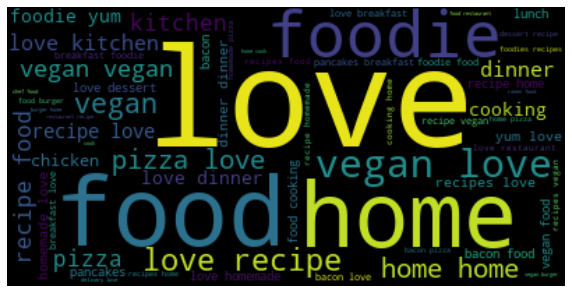

In [43]:
# Get string of hashtags
text = " ".join(hashtag for hashtag in df.hashtag)

# Generate wordcloud image
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=100, max_words=100, background_color="black", mode="RGBA").generate(text)

# Display wordcloud image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
image_path = r'C:\Users\raide\OneDrive\Documents\GitHub\capstone_project\images'
data_files = [f.rsplit('.', 1)[0] for f in listdir(data_path) if isfile(join(data_path, f))]
plt.savefig(image_path + '//' + data_files[-1] + '.png', format="png")
plt.show()